# Drafty implementation of SRCNN

https://arxiv.org/pdf/1501.00092v3.pdf

https://paperswithcode.com/paper/image-super-resolution-using-deep

In [ ]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path, PurePath


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import RandomNormal

# Check GPUs:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
EPOCHS = 20
BATCH_SIZE = 64
DOWNSAMPLE_FACTOR = 4
DOWNSAMPLE_METHOD = cv2.INTER_CUBIC
#HEIGHT, WIDTH = (28, 28)
HEIGHT, WIDTH = (None, None)

# Load MNIST

http://yann.lecun.com/exdb/mnist/

In [ ]:
(y_train, train_labels) , (y_test, test_labels) = mnist.load_data()

# Downsample (and upsample) images

Currently downsampling and upsampling to degrade the image (this is most in line with the original paper).

- x is input to the neural net and is the degraded (downsampled+upsampled) image
- y is ground truth (the HR, undegraded image)

In [ ]:
def degrade_image(img, factor):
    #print(img.shape)
    h, w = img.shape
    new_height = int(h / factor)
    new_width = int(w / factor)

    # resize the image - down
    img = cv2.resize(img, (new_width, new_height), interpolation = DOWNSAMPLE_METHOD)

    # resize the image - up
    img = cv2.resize(img, (w, h), interpolation = DOWNSAMPLE_METHOD)

    # save the image
    #print(img.shape)
    return img

In [ ]:
x_train = np.array([degrade_image(image, DOWNSAMPLE_FACTOR) for image in y_train])
x_test = np.array([degrade_image(image, DOWNSAMPLE_FACTOR) for image in y_test])

## (Expanding dimensions)

Necessary to be compatible with vanilla Conv2D Keras layer.

In [ ]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

# Building the model

It is really quite straight-forward.

In [ ]:
def build_srcnn():
    
    srcnn = Sequential()
    
    srcnn.add(Conv2D(filters=128, kernel_size = (9, 9), 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.001, seed=None),
                     bias_initializer='zeros',
                     activation='relu', padding='same', use_bias=True, input_shape=(HEIGHT, WIDTH, 1)))
    
    srcnn.add(Conv2D(filters=64, kernel_size = (1, 1), 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.001, seed=None),
                     bias_initializer='zeros',
                     activation='relu', padding='same', use_bias=True))
    
    srcnn.add(Conv2D(filters=1, kernel_size = (5, 5), 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.001, seed=None), 
                     bias_initializer='zeros',
                     activation='linear', padding='same', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    srcnn.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return srcnn

srcnn = build_srcnn()
srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
history = srcnn.fit(x_train, 
                    y_train, epochs = EPOCHS, 
                    batch_size = BATCH_SIZE,
                    validation_data = (x_test, y_test)
                   )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 148us/sample - loss: 2702.3363 - mean_squared_error: 2702.3354 - val_loss: 2360.1192 - val_mean_squared_error: 2360.1196
Epoch 2/20
60000/60000 [==============================] - 7s 122us/sample - loss: 2305.4998 - mean_squared_error: 2305.5007 - val_loss: 2203.5693 - val_mean_squared_error: 2203.5688
Epoch 3/20
60000/60000 [==============================] - 7s 116us/sample - loss: 2174.8334 - mean_squared_error: 2174.8320 - val_loss: 2093.3659 - val_mean_squared_error: 2093.3665
Epoch 4/20
60000/60000 [==============================] - 7s 114us/sample - loss: 2097.8334 - mean_squared_error: 2097.8328 - val_loss: 2039.6858 - val_mean_squared_error: 2039.6854
Epoch 5/20
60000/60000 [==============================] - 6s 108us/sample - loss: 2054.8037 - mean_squared_error: 2054.8044 - val_loss: 2009.0258 - val_mean_squared_error: 2009.0258
Epoch 6/20
60000/60000 [================

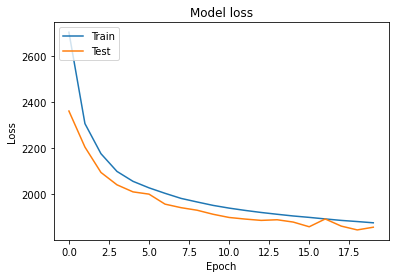

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Anecdotal comparison of predict vs ground truth

In [ ]:
def plot_comparison(x, y, label):
    sr = srcnn.predict(np.expand_dims(x, axis = 0))
    #print(sr.shape)
    #print(x.shape, y.shape)
    fig = plt.figure(figsize = (10,10))
    
    ax0 = fig.add_subplot(1,3,1)
    ax0.set_title('LR' + ', bicubic interpolation')
    ax0 = plt.imshow(x[:,:,0], cmap = 'gray')
    
    ax1 = fig.add_subplot(1,3,2)
    ax1.set_title('SRCNN')
    ax1 = plt.imshow(sr[0,:,:,0], cmap = 'gray')
    
    ax2 = fig.add_subplot(1,3,3)
    ax2.set_title('HR (ground truth) - ' + str(label))
    ax2 = plt.imshow(y[:,:,0], cmap = 'gray')

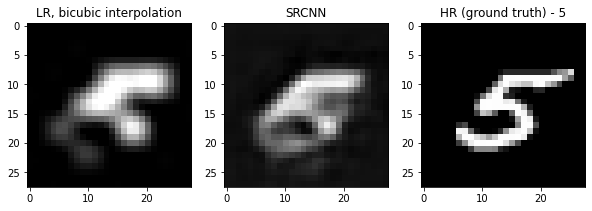

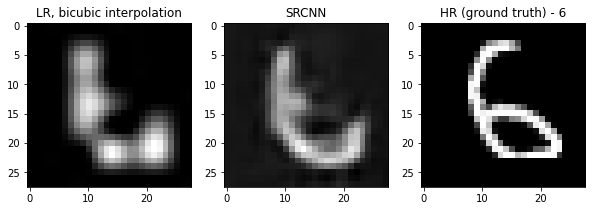

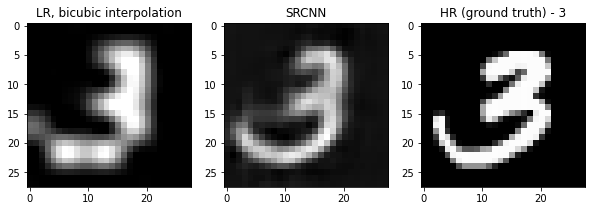

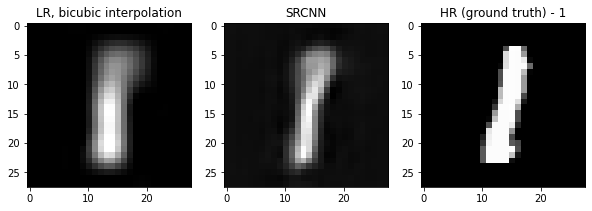

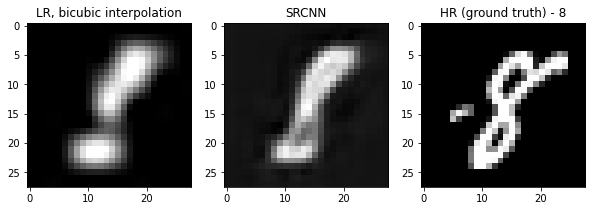

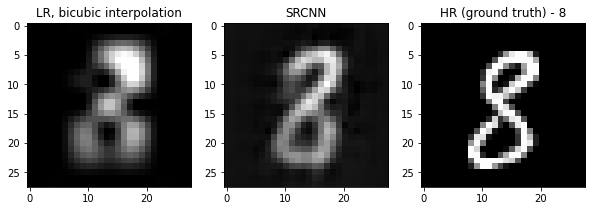

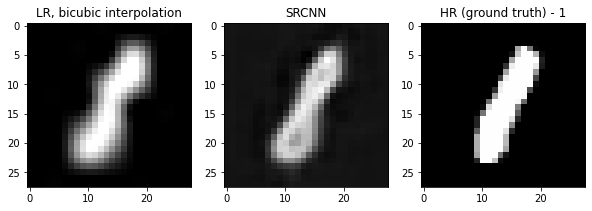

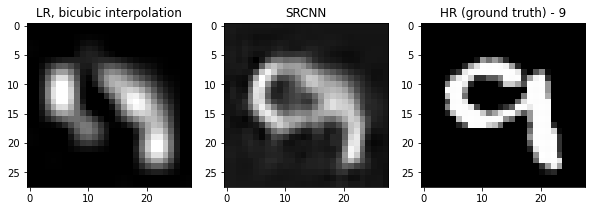

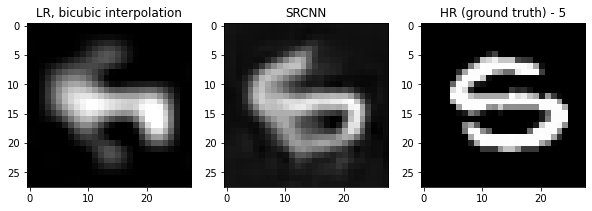

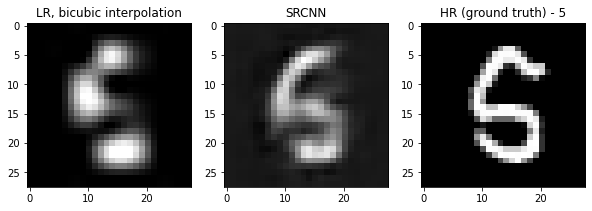

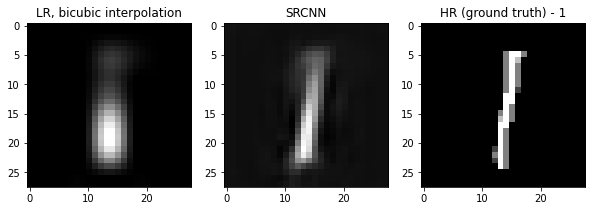

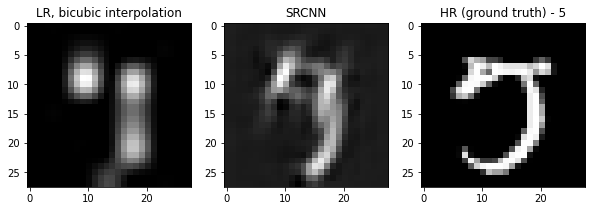

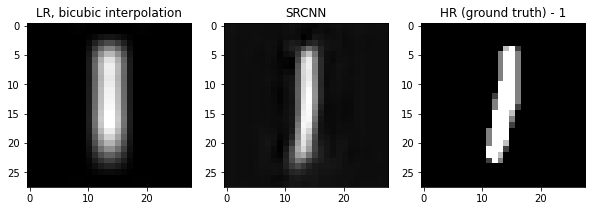

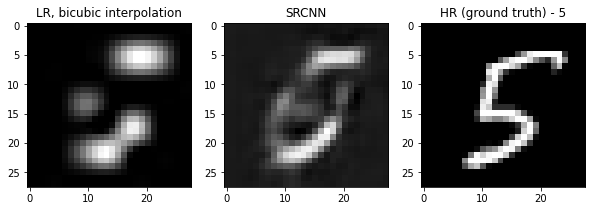

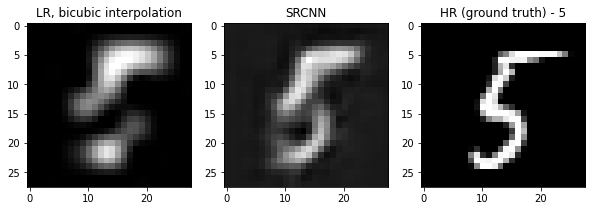

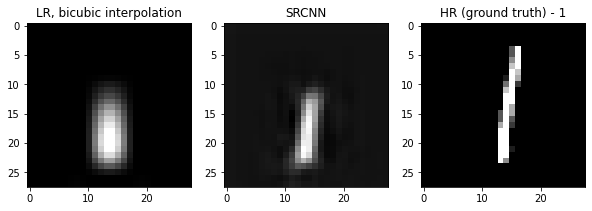

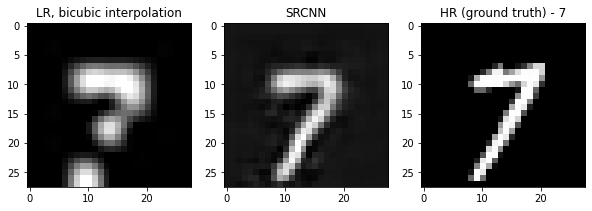

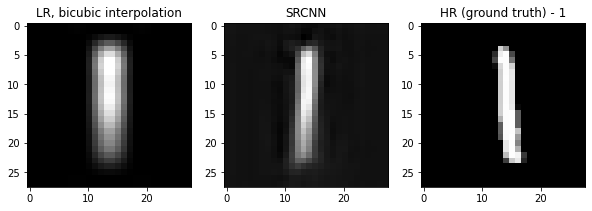

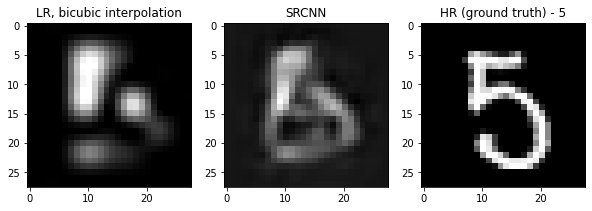

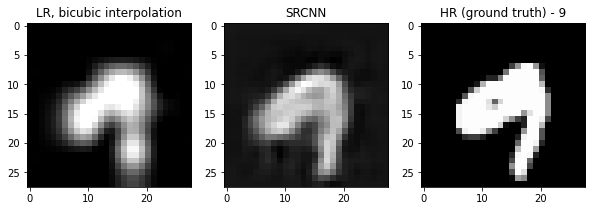

In [ ]:
len_test = len(x_test)
random_idxs = np.random.randint(0, len_test, size = 20)
for idx in random_idxs:
    plot_comparison(x_test[idx,:,:,:], y_test[idx,:,:,:], test_labels[idx])

# Below is only scratchpad - not to be run
https://github.com/Shritesh99/Image_Super_Resolution/blob/master/SRCNN.ipynb